In [1]:
import scipy as sp
import scipy.io
import scipy.stats
import os
import numpy as np
import pandas as pd
import glob
import csv
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import pdvega
import matplotlib.patches as patch
from matplotlib import gridspec


In [2]:
trial_onsets = sp.io.loadmat('trialOnsets.mat')['trialOnsets']
lick_onsets = sp.io.loadmat('lickOnsets.mat')['lickOnsetTime'][0]

In [3]:
columns = list(sp.io.loadmat('trialOnsets.mat')['trialOnsets'].dtype.names)
columns.append(columns.pop(4))
columns

['supra',
 'thres',
 'sub',
 'mini',
 'whisker_supra',
 'whisker_thres',
 'whisker_sub',
 'whisker_mini',
 'whisker']

In [4]:
all_trial_onsets = [trial_onsets[type][0][0][0] for type in columns]
tr_onsets_sort = {col:trial_type for col, trial_type in zip(columns, all_trial_onsets)}

In [5]:
trial_length = np.median(np.diff(np.sort(np.concatenate(all_trial_onsets))))

In [6]:
log_df = pd.DataFrame(tr_onsets_sort).iloc[:,[0,1,3,2,5,6,8,7,4]]
log_df = log_df.melt(var_name = 'trial_type', value_name = 'trial_onset')
log_df['trial_onset'] = log_df['trial_onset'] - 0.05 #whisker stim was 0.05s before first laser onset
log_df['trial_offset'] = log_df['trial_onset']+trial_length
log_df.head()

,trial_type,trial_onset,trial_offset
0,mini,19.087200,26.227167
1,mini,69.047533,76.187500
2,mini,118.956600,126.096567
3,mini,168.966300,176.106267
4,mini,218.886133,226.026100


In [7]:
log_df['trial_type'].unique()

array(['mini', 'sub', 'thres', 'supra', 'whisker_mini', 'whisker_sub',
       'whisker_thres', 'whisker_supra', 'whisker'], dtype=object)

In [8]:
log_df['licks'] = log_df.apply(lambda x: [lick_onsets[(lick_onsets>= x['trial_onset']) & (lick_onsets <= x['trial_offset'])]], axis = 1)
log_df['licks'] = log_df['licks'].apply(lambda x: x[0])
log_df['licks'] = log_df.apply(lambda x: x['licks'] - x['trial_onset'] if len(x['licks'])>0 else [], axis = 1)
log_df.head()

,trial_type,trial_onset,trial_offset,licks
0,mini,19.087200,26.227167,[]
1,mini,69.047533,76.187500,[]
2,mini,118.956600,126.096567,[]
3,mini,168.966300,176.106267,[]
4,mini,218.886133,226.026100,[]


In [9]:
log_df['laser_int'] = 0
log_df.loc[log_df['trial_type'].str.contains('mini'), 'laser_int'] = 1
log_df.loc[log_df['trial_type'].str.contains('sub'), 'laser_int'] = 2
log_df.loc[log_df['trial_type'].str.contains('thres'), 'laser_int'] = 3
log_df.loc[log_df['trial_type'].str.contains('supra'), 'laser_int'] = 4

In [10]:
edges = np.arange(-0.25, 2.5, 0.01)
log_df['lick_counts'] = log_df['licks'].apply(lambda x: np.histogram(x, bins = edges)[0])

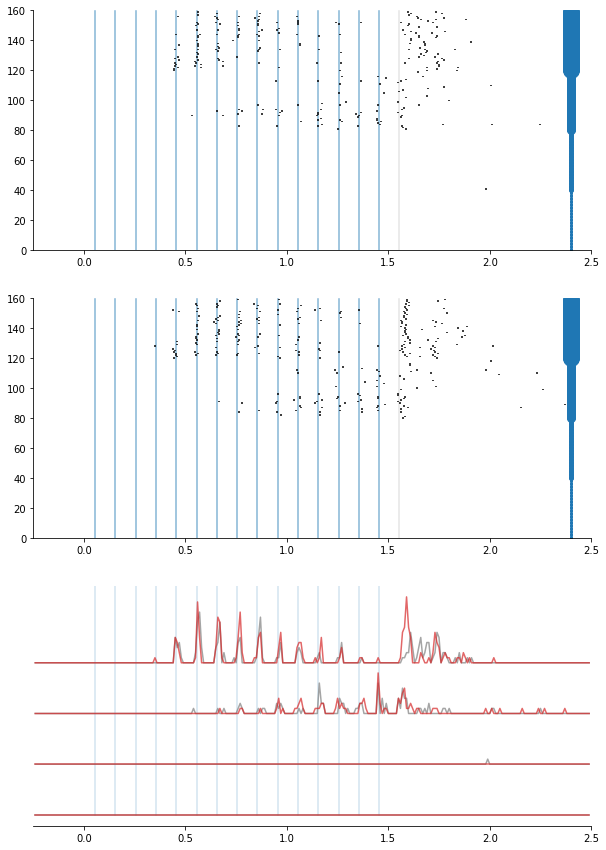

In [11]:
mpl.close('all')
fig = mpl.figure(figsize = (10, 15))

ax1 = fig.add_subplot(311)

no_whisker = log_df.loc[~log_df['trial_type'].str.contains('whisker'),:]
for trial,licks in enumerate(no_whisker['licks']):
    [mpl.vlines(lick, trial-0.5, trial+0.5) for lick in licks]
    ax1.scatter(2.4, trial, s = 4**(no_whisker.iloc[trial]['laser_int']), color = 'C0')


ax2 = fig.add_subplot(312)
laser_whisker = log_df.loc[log_df['trial_type'].str.contains('whisker_'),:]
for trial,licks in enumerate(laser_whisker['licks']):
    [mpl.vlines(lick, trial-0.5, trial+0.5) for lick in licks]
    ax2.scatter(2.4, trial, s = 4**(laser_whisker.iloc[trial]['laser_int']), color = 'C0')

for ax in [ax1,ax2]:
    ax.set_xlim(-0.25,2.5), ax.set_ylim(0,160)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.add_patch(patch.Rectangle([0.05+.1*i, 0], 0.005, 160, color = 'C0', alpha = 0.3)) for i in range(int(1.5/.1))]
    ax.add_patch(patch.Rectangle([0.05+.1*15, 0], 0.005, 160, color = 'C7', alpha = 0.1))
    
### psths ###############################    
ax3 = fig.add_subplot(3,1,3)
# ax4 = fig.add_subplot(3,1,4)  
colors = iter(['C7', 'C3'])

for cond in [no_whisker, laser_whisker]:
    color = next(colors)
    for offset, t_type in enumerate(cond['trial_type'].unique()):
        l_counts = cond.loc[cond['trial_type'] == t_type, 'lick_counts']
        hist = np.mean((np.vstack(l_counts.as_matrix())), axis = 0)
        sd_hist = np.std((np.vstack(l_counts.as_matrix())), axis = 0)
        ax3.plot(edges[1:], hist+offset/4, color = color, alpha = 0.7)
#         ax4.plot(edges[1:], sd_hist+offset/2, color = color, alpha = 0.7)

[ax3.add_patch(patch.Rectangle([0.05+.1*i, 0], 0.005, 160, color = 'C0', alpha = 0.1)) for i in range(int(1.5/.1))]
ax3.plot
for ax in [ax3]:
    ax.set_xlim(-0.25, 2.5)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_visible(False)

fig

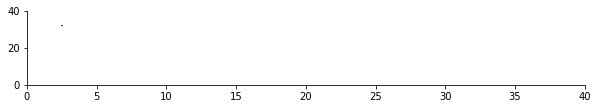

In [12]:
fig2 = mpl.figure(figsize = (10,3))

ax1 = fig2.add_subplot(211)

only_whisker = log_df.loc[log_df['trial_type']=='whisker',:]
for trial,licks in enumerate(only_whisker['licks']):
    [mpl.vlines(lick, trial-0.25, trial+0.5) for lick in licks]
    
ax1.set_xlim(0,only_whisker.shape[0])
ax1.set_ylim(0,only_whisker.shape[0])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig2

In [13]:
clusters_f = sp.io.loadmat('clusteredSpikes.mat')
clusters = clusters_f['spikeTimes']
chan_num = clusters_f['numChans']

In [14]:
clusters = np.array([np.concatenate(clust) for clust in clusters[0]])

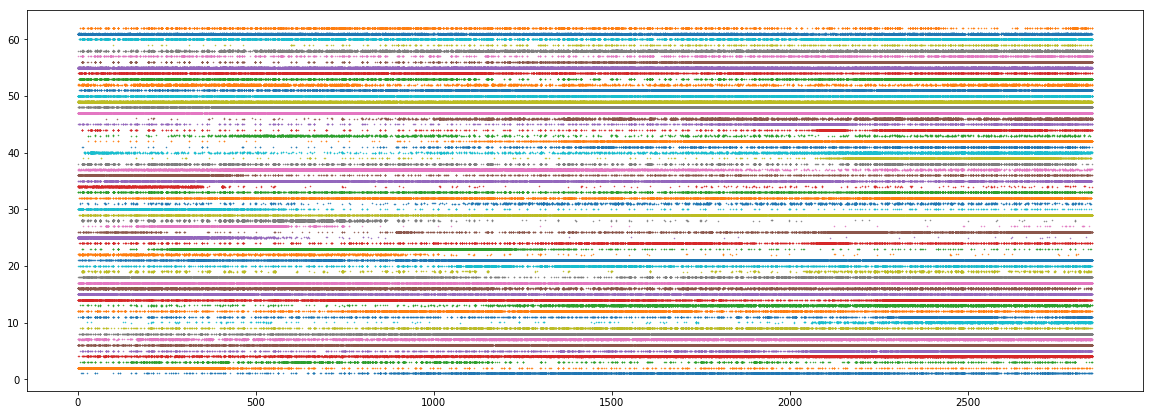

In [15]:
fig3 = mpl.figure(figsize = (20,7))
for offset, clust in enumerate(clusters):
    jitter = np.random.rand(clust.size)*.05
    mpl.scatter(clust, np.ones(clust.size)+jitter+offset,marker = '.', s = 1)
    
fig3

In [16]:
clust_ff = []
for offset, clust in enumerate(clusters):
    hist = np.histogram(clust,bins = np.arange(0,3000,100))[0]
    clust_ff.append(np.std(hist)/np.mean(hist))

order = np.argsort(clust_ff)
clusters = clusters[order]
chan_num = chan_num[0][order]

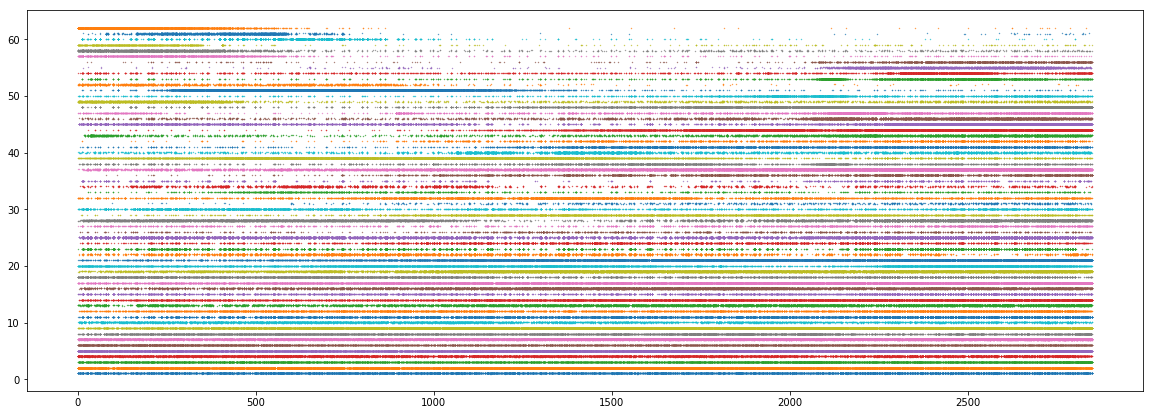

In [64]:
mpl.close('all')
fig4 = mpl.figure(figsize = (20,7))
for offset, clust in enumerate(clusters):
    jitter = np.random.rand(clust.size)*.05
    mpl.scatter(clust, np.ones(clust.size)+jitter+offset,marker = '.', s = 0.5)
    
fig4

In [18]:
def sort_clust(clust): 
    return log_df.apply(lambda x: [clust[(clust>=x['trial_onset']-1) & 
                                          (clust<=x['trial_offset']-1)] - x['trial_onset']] ,axis = 1)
    
col_names = ['clust'+str(i) for i in range(len(clusters))]    
sorted_clusts = pd.DataFrame([sort_clust(clust) for clust in clusters], index = col_names).T
sorted_clusts = sorted_clusts.applymap(lambda x: x[0])
log_df = pd.concat([log_df, sorted_clusts], axis = 1)
log_df.head(3)

,trial_type,trial_onset,trial_offset,licks,laser_int,lick_counts,clust0,clust1,clust2,clust3,...,clust52,clust53,clust54,clust55,clust56,clust57,clust58,clust59,clust60,clust61
0,mini,19.087200,26.227167,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.3289666666666662, 0.44229999999999947, 0.9...","[-0.9819666666666649, -0.8795333333333311, -0....","[0.2472666666666683, 2.648500000000002, 2.7545...","[-0.9992333333333328, -0.8776666666666664, -0....",...,[],[4.907133333333334],[],[],"[2.3598333333333343, 2.560100000000002, 2.6998...","[-0.6357999999999997, -0.33616666666666717, 0....","[-0.8203999999999994, -0.6731333333333325, -0....",[],[],"[0.12989999999999924, 0.13816666666666677, 0.1..."
1,mini,69.047533,76.187500,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.5001000000000033, -0.11213333333333253, 0....","[-0.8609000000000009, -0.8290999999999968, -0....","[-0.7271666666666619, -0.3753333333333302, 1.4...","[-0.9980666666666735, -0.8685333333333318, -0....",...,[1.9872333333333358],"[1.958833333333331, 1.9788666666666614, 1.9961...",[],[],"[-0.26073333333333437, -0.19496666666667295, 0...","[-0.9547666666666714, -0.8184666666666658, -0....","[-0.9758999999999958, -0.7934333333333399, -0....",[],[],"[-0.9372666666666731, -0.9206000000000074, -0...."
2,mini,118.956600,126.096567,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.6853333333333467, -0.29503333333333615, -0...","[-0.9642333333333397, -0.8386333333333482, -0....","[-0.9514000000000067, -0.24693333333334522, 0....","[-0.9635666666666793, -0.9176666666666762, -0....",...,[],[],[],[],"[-0.7597666666666782, -0.7022333333333393, -0....","[-0.9438333333333446, -0.8137666666666803, -0....","[-0.9616666666666731, -0.8016666666666765, -0....",[],[5.018899999999988],"[-0.9227333333333405, -0.9096333333333462, -0...."


In [19]:
id_vars = ['trial_type', 'trial_onset', 'trial_offset', 'licks', 'laser_int', 'lick_counts']
log_df = log_df.melt(id_vars = id_vars, var_name = 'cluster', value_name = 'spikes')
columns = list(log_df.columns)
columns = ['cluster'] + columns
columns.pop(7)
log_df = log_df[columns]
log_df.head()

,cluster,trial_type,trial_onset,trial_offset,licks,laser_int,lick_counts,spikes
0,clust0,mini,19.087200,26.227167,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.3289666666666662, 0.44229999999999947, 0.9..."
1,clust0,mini,69.047533,76.187500,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.5001000000000033, -0.11213333333333253, 0...."
2,clust0,mini,118.956600,126.096567,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.6853333333333467, -0.29503333333333615, -0..."
3,clust0,mini,168.966300,176.106267,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.9913666666666643, -0.981899999999996, -0.9..."
4,clust0,mini,218.886133,226.026100,[],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.4898333333333369, -0.3238666666666745, 0.1..."


In [21]:
no_whisker.shape[0]

160

In [123]:
def plot_rast(df,ax,window, laser = True):
    mpl.sca(ax)
    for trial in range(df.shape[0]):
        [mpl.vlines(lick, trial-0.5, trial+0.5, color = 'r') for lick in df.loc[trial, 'licks']]
        spikes = df.loc[trial, 'spikes']
        spikes = spikes[(spikes >= window[0]) & (spikes <= window[1])]
        [mpl.vlines(spike, trial-0.5, trial+0.5) for spike in spikes]
        if laser:
            ax.scatter(window[1]+window[1]*.1, trial, s = 4**(df.iloc[trial]['laser_int']), color = 'C0', clip_on=False)


In [121]:
def prettify(ax, xlim, ylim, laser = True):
    ax.set_xlim(xlim), ax.set_ylim(ylim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if laser:
        [ax.add_patch(patch.Rectangle([0.05+.1*i, 0], 0.005, 160, color = 'C0', alpha = 0.3)) for i in range(int(1.5/.1))]
        ax.add_patch(patch.Rectangle([0.05+.1*15, 0], 0.005, 160, color = 'C7', alpha = 0.1))


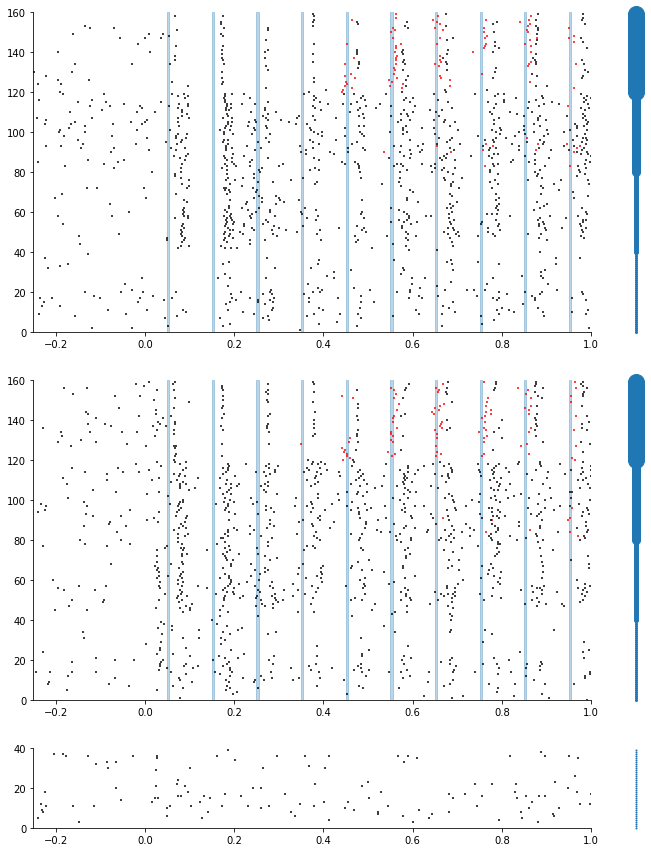

In [122]:
ex_clust = log_df[log_df['cluster'] == 'clust11']

mpl.close('all')
fig = mpl.figure(figsize = (10, 15))
gs = gridspec.GridSpec(3,1, height_ratios = [4,4,1])
window = [-0.25,1]

ax1 = mpl.subplot(gs[0])
no_whisker = ex_clust.loc[~ex_clust['trial_type'].str.contains('whisker'),:].reset_index(drop=True)
plot_rast(no_whisker,ax1,window)
# ax1.scatter(2.5, trial, s = 4**(no_whisker.iloc[trial]['laser_int']), color = 'C0')

ax2 = mpl.subplot(gs[1])
laser_whisker = ex_clust.loc[ex_clust['trial_type'].str.contains('whisker_'),:].reset_index(drop=True)
plot_rast(laser_whisker,ax2,window)
# ax1.scatter(2.5, trial, s = 4**(no_whisker.iloc[trial]['laser_int']), color = 'C0')
    
ax3 = mpl.subplot(gs[2])
only_whisker = ex_clust.loc[ex_clust['trial_type']=='whisker',:].reset_index(drop=True)
plot_rast(only_whisker,ax3,window, laser = False)

prettify(ax1, window, [0,160])
prettify(ax2, window, [0,160])
prettify(ax3, window, [0,40], laser = False)

fig

In [97]:
list(log_df.columns)

['cluster',
 'trial_type',
 'trial_onset',
 'trial_offset',
 'licks',
 'laser_int',
 'lick_counts',
 'spikes']

In [ ]:
spikes